# The goal of this notebook is to extract and analyze the text data available in the EDGAR tool

In [1]:
import pandas as pd
import requests
from datetime import datetime
import json
import os

### Define the Header and import the S&P 500 Company data

In [6]:
sp = pd.read_csv('./data/sp500.csv')


In [7]:
it = sp[sp['GICS Sector']=='Information Technology']
cs = sp[sp['GICS Sector']=='Communication Services']
cd = sp[sp['GICS Sector']=='Consumer Discretionary']
df = pd.concat([it, cs, cd], ignore_index=True)

In [27]:
pd.reset_option('all')

/var/folders/0w/q70p80s12nz5lpzr087614lw0000gn/T/ipykernel_92281/2786130087.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
/var/folders/0w/q70p80s12nz5lpzr087614lw0000gn/T/ipykernel_92281/2786130087.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


# Parsing the text from the 10-K filings

In [57]:
import re
import os
import pandas as pd
import glob
from bs4 import BeautifulSoup, XMLParsedAsHTMLWarning
import warnings
warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

# Configuration
companies = list(df['Symbol'].values) # List of company tickers to process
base_dir = './data/sec_filings/'

# List to store data for all companies and all sections
all_data = []

# Section patterns and display names
section_patterns = {
    "Business": {
        "start_patterns": [r'ITEM\s+1\.\s*', r'Item\s+1\.\s*'],
        "end_patterns": [r'ITEM\s+1A\.\s*', r'Item\s+1A\.\s*', r'ITEM\s+1\.A\.\s*', r'Item\s+1\.A\.\s*', r'ITEM\s+2\.\s*', r'Item\s+2\.\s*'],
        "display_name": "Item 1. Business"
    },
    "Risk Factors": {
        "start_patterns": [r'ITEM\s+1A\.\s*', r'Item\s+1A\.\s*'],
        "end_patterns": [r'ITEM\s+1B\.\s*', r'Item\s+1B\.\s*', r'ITEM\s+1C\.\s*', r'Item\s+1C\.\s*', r'ITEM\s+2\.\s*', r'Item\s+2\.\s*'],
        "display_name": "Item 1A. Risk Factors"
    },
    "Cybersecurity": {
        "start_patterns": [r'ITEM\s+1C\.\s*', r'Item\s+1C\.\s*'],
        "end_patterns": [r'ITEM\s+2\.\s*', r'Item\s+2\.\s*'],
        "display_name": "Item 1C. Cybersecurity"
    },
    "Properties": {
        "start_patterns": [r'ITEM\s+2\.\s*', r'Item\s+2\.\s*'],
        "end_patterns": [r'ITEM\s+3\.\s*', r'Item\s+3\.\s*'],
        "display_name": "Item 2. Properties"
    },
    "Legal Proceedings": {
        "start_patterns": [r'ITEM\s+3\.\s*', r'Item\s+3\.\s*'],
        "end_patterns": [r'ITEM\s+4\.\s*', r'Item\s+4\.\s*'],
        "display_name": "Item 3. Legal Proceedings"
    },
    "Management Discussion and Analysis": {
        "start_patterns": [r'ITEM\s+7\.\s*', r'Item\s+7\.\s*'],
        "end_patterns": [r'ITEM\s+7A\.\s*', r'Item\s+7A\.\s*', r'ITEM\s+7\.A\.\s*', r'Item\s+7\.A\.\s*'],
        "display_name": "Item 7. Management Discussion and Analysis"
    },
    "Quantitative and Qualitative Disclosures": {
        "start_patterns": [r'ITEM\s+7A\.\s*', r'Item\s+7A\.\s*'],
        "end_patterns": [r'ITEM\s+8\.\s*', r'Item\s+8\.\s*'],
        "display_name": "Item 7A. Quantitative and Qualitative Disclosures about Market Risk"
    },
}

# Find all 10-K files for specified companies
file_paths = []
for ticker in companies:
    pattern = f"{base_dir}{ticker}_10-K_*.html"
    ticker_files = glob.glob(pattern)
    file_paths.extend(ticker_files)

if not file_paths:
    print("No matching files found. Please check the directory and file naming pattern.")
else:
    print(f"Found {len(file_paths)} files to process.")

    # Process each file
    for html_file_path in file_paths:
        if not os.path.exists(html_file_path):
            print(f"Error: File not found at '{html_file_path}'")
            continue

        try:
            # Extract ticker from filename
            base_filename = os.path.basename(html_file_path)
            ticker = base_filename.split('_')[0]

            # Extract date from filename
            parts = base_filename.split('_')
            filing_date = parts[2].split('.')[0] if len(parts) >= 3 else None

            # Read the HTML file
            with open(html_file_path, 'r', encoding='utf-8') as f:
                html_content = f.read()

            # Parse the HTML
            soup = BeautifulSoup(html_content, 'lxml')

            # Extract Text
            text_content = soup.get_text(separator=" ", strip=True)

            # Clean the text
            text_lines = text_content.splitlines()
            cleaned_lines = []
            for line in text_lines:
                processed_line = re.sub(r'[ \t]+', ' ', line).strip()
                if processed_line:
                    cleaned_lines.append(processed_line)
            final_text = "\n".join(cleaned_lines)

            # Sections to extract
            section_names_to_extract = [
                "Business",
                "Risk Factors",
                "Cybersecurity",
                "Properties",
                "Legal Proceedings",
                "Management Discussion and Analysis",
                "Quantitative and Qualitative Disclosures"
            ]

            # Extract all sections and store results
            for section_name_key in section_names_to_extract:
                section_config = section_patterns[section_name_key]
                start_patterns = section_config["start_patterns"]
                end_patterns = section_config["end_patterns"]
                display_name = section_config["display_name"]

                valid_sections = []
                for start_pattern in start_patterns:
                    for start_match in re.finditer(start_pattern, final_text, re.IGNORECASE):
                        start_pos = start_match.start()
                        search_start = start_pos + len(start_match.group())

                        for end_pattern in end_patterns:
                            end_match = re.search(end_pattern, final_text[search_start:], re.IGNORECASE)
                            if end_match:
                                end_pos = search_start + end_match.start()
                                section_content = final_text[start_pos:end_pos].strip()
                                section_content = re.sub(start_pattern, '', section_content, flags=re.IGNORECASE).strip()

                                min_content_length = 200
                                if len(section_content) > min_content_length:
                                    valid_sections.append({
                                        'content': section_content,
                                        'length': len(section_content),
                                        'display_name': display_name
                                    })
                                break # Found an end pattern for this start, move to next start_match if any

                if valid_sections:
                    main_section = max(valid_sections, key=lambda x: x['length'])
                    section_content_extracted = main_section['content']
                    section_display_name = main_section['display_name']
                    print(f"Successfully extracted {section_display_name} section for {ticker} (filing date: {filing_date})")
                else:
                    section_content_extracted = ""
                    section_display_name = display_name
                    print(f"No {section_name_key} section found for {ticker}. Check the patterns or document structure.")

                all_data.append({
                    'ticker': ticker,
                    'filing_date': filing_date,
                    'section': section_display_name,
                    'content': section_content_extracted
                })

        except Exception as e:
            print(f"Error processing {html_file_path}: {e}")

# Create DataFrame with all sections
if all_data:
    long_df = pd.DataFrame(all_data)
    print("Processing complete!")
else:
    print("No data was extracted. Please check the file paths and contents.")

Found 1334 files to process.
Successfully extracted Item 1. Business section for ACN (filing date: 2022-08-31)
Successfully extracted Item 1A. Risk Factors section for ACN (filing date: 2022-08-31)
No Cybersecurity section found for ACN. Check the patterns or document structure.
Successfully extracted Item 2. Properties section for ACN (filing date: 2022-08-31)
Successfully extracted Item 3. Legal Proceedings section for ACN (filing date: 2022-08-31)
Successfully extracted Item 7. Management Discussion and Analysis section for ACN (filing date: 2022-08-31)
Successfully extracted Item 7A. Quantitative and Qualitative Disclosures about Market Risk section for ACN (filing date: 2022-08-31)
Successfully extracted Item 1. Business section for ACN (filing date: 2024-08-31)
Successfully extracted Item 1A. Risk Factors section for ACN (filing date: 2024-08-31)
Successfully extracted Item 1C. Cybersecurity section for ACN (filing date: 2024-08-31)
Successfully extracted Item 2. Properties secti

In [58]:
# Starting with your long_df, get latest filing dates
long_df['filing_date'] = pd.to_datetime(long_df['filing_date'])
latest_dates = long_df.groupby('ticker')['filing_date'].max().reset_index()
latest_filings = long_df.merge(latest_dates, on=['ticker', 'filing_date'])

# Merge with sp dataframe on ticker/Symbol
merged_df = latest_filings.merge(sp, left_on='ticker', right_on='Symbol', how='left')

merged_df.describe()

,filing_date,Unnamed: 0,CIK
count,987,987.000000,9.870000e+02
mean,2024-11-14 16:00:00,260.695035,9.585510e+05
min,2024-03-29 00:00:00,4.000000,2.488000e+03
25%,2024-09-30 00:00:00,140.000000,7.963430e+05
50%,2024-12-31 00:00:00,283.000000,1.013462e+06
75%,2024-12-31 00:00:00,385.000000,1.326801e+06
max,2025-02-28 00:00:00,500.000000,1.754301e+06
std,NaN,145.060808,4.763250e+05


### I will only take in the latest value (2024)

In [59]:
merged_df.to_csv('./data/df_latest_filings.csv', index=False)
merged_df = pd.read_csv('./data/df_latest_filings.csv')
merged_df = merged_df.dropna(subset=['content'])


In [73]:
merged_df.tail(3)

,ticker,filing_date,section,content,Unnamed: 0,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
151,WBD,2024-12-31,Item 3. Legal Proceedings,"Legal Proceedings. From time to time, in the n...",484,WBD,Warner Bros. Discovery,Communication Services,Broadcasting,"New York City, New York",2022-04-11,1437107,2022 (Warner Bros. 1923)
152,WBD,2024-12-31,Item 7. Management Discussion and Analysis,Management’s Discussion and Analysis of Financ...,484,WBD,Warner Bros. Discovery,Communication Services,Broadcasting,"New York City, New York",2022-04-11,1437107,2022 (Warner Bros. 1923)
153,WBD,2024-12-31,Item 7A. Quantitative and Qualitative Disclosu...,Quantitative and Qualitative Disclosures about...,484,WBD,Warner Bros. Discovery,Communication Services,Broadcasting,"New York City, New York",2022-04-11,1437107,2022 (Warner Bros. 1923)


In [74]:
from questions import company_10k_questions
all_rows_with_questions = []

# Iterate over each row in the merged_df
# Using itertuples(index=False) and zipping with columns for robust column name handling
for row_tuple in merged_df.itertuples(index=False):
    # Create a dictionary from the row tuple using original column names
    original_row_dict = dict(zip(merged_df.columns, row_tuple))

    company_name = original_row_dict.get('Security', 'Unknown Company') # Default if 'Security' is missing
    section_from_df = original_row_dict.get('section')

    if section_from_df is None:
        # Skip row if 'section' column is missing or None
        continue

    # Normalize the section name from DataFrame to match dictionary keys
    # (e.g., "Item 1. Business" to "Item 1: Business")
    section_from_df = section_from_df.strip()
    dict_key = section_from_df.replace(". ", ": ", 1)

    questions_list = company_10k_questions.get(dict_key)

    if questions_list:
        for question_template in questions_list:
            # Format the question with the company name
            formatted_question = question_template.format(company_name=company_name)
            
            # Create a new dictionary for the new row, copying original data
            new_row_entry = original_row_dict.copy()
            new_row_entry['Formatted_Question'] = formatted_question
            
            all_rows_with_questions.append(new_row_entry)
    else:
        # Optionally handle cases where a section in df doesn't match any key in questions dict
        print(f"No questions found for section: {section_from_df} (mapped to {dict_key})")


# Create the new DataFrame with each question as a row
expanded_df = pd.DataFrame(all_rows_with_questions)

# Question/Answer on the 10-K

In [75]:
expanded_df['question_prompt'] = (
 "As financial analysts, we are extracting financial data from the 10-K, more specifically the " +
expanded_df['section'] + " section of the 10-K for the company " + expanded_df['Security'] +
", which is generally operating in the " + expanded_df['GICS Sector'] +
" GICS Sector, specifically the " + expanded_df['GICS Sub-Industry'] + " GICS Sub-Industry.\n" +
"You are an information extraction bot. **Strictly adhere to the text in the \"" + expanded_df['section'] +
"\" section to answer the questions below.**\n" +
"**IMPORTANT: Your response must be ONLY a valid JSON object in this exact format:**\n" +
"{\n" +
" \"question\": \"" + expanded_df['Formatted_Question'] + "\",\n" +
" \"answer\": \"[Your detailed paragraph answer here]\",\n" +
" \"supporting_quote\": \"[Exact quote from the text that supports your answer]\",\n" +
" \"swot_category\": \"[One of: Strength, Weakness, Opportunity, Threat]\",\n" +
" \"confidence\": [Your confidence score from 0.0 to 1.0]\n" +
"}\n" +
"**Guidelines:**\n" +
"- Answer must be a complete paragraph, no bullet points or internal lists\n" +
"- Supporting quote must be an exact excerpt from the provided text\n" +
"- SWOT category determination:\n" +
"  - **Strength**: Positive internal factors that give the company advantages (e.g., strong market position, unique capabilities, competitive advantages)\n" +
"  - **Weakness**: Negative internal factors that put the company at a disadvantage (e.g., operational inefficiencies, resource limitations, competitive disadvantages)\n" +
"  - **Opportunity**: Positive external factors the company could exploit (e.g., market growth, emerging trends, regulatory changes that benefit)\n" +
"  - **Threat**: Negative external factors that could harm the company (e.g., competition, regulatory risks, market decline, economic headwinds)\n" +
"- Confidence should reflect how directly the information answers the question (1.0 = perfect match, 0.0 = no relevant information)\n" +
"- If information is not explicitly present, set answer to \"Information not available in this section.\", swot_category to \"Not Applicable\", and confidence to 0.0\n" +
"- Do not include any text outside the JSON object\n" +
"GICS Sector: " + expanded_df['GICS Sector'] + "\n" +
"GICS Sub-Industry: " + expanded_df['GICS Sub-Industry'] + "\n" +
"**" + expanded_df['section'] + " Text:**\n" +
expanded_df['content'] + "\n" +
"---\n" +
"**Question:** " + expanded_df['Formatted_Question']
)

### 1. PipeLine, Ask the questions to Gemini

In [32]:
import pandas as pd
import google.generativeai as genai
import time
import os

api_key = os.getenv('GEMINI_API_KEY')
# Configure the API key
genai.configure(api_key=api_key)

# Initialize the model with low temperature
model = genai.GenerativeModel(
    'gemini-2.5-flash-preview-05-20',
    generation_config={
        'temperature': 0.01, # Low temperature for more deterministic responses for reproducibility
        'top_p': 0.95, # Top-p sampling for diversity
        'response_mime_type': 'application/json'  # Force JSON output
    }
)

In [61]:
import json
import time

def process_dataframe_with_gemini(df, file_name, prompt_column='question_prompt', max_retries=3):
    responses = []
    gemini_responses = []
    
    for index, row in df.iterrows():
        print(f"Processing row {index + 1}/{len(df)}: {row['section']}")
        
        retry_count = 0
        success = False
        
        while retry_count < max_retries and not success:
            try:
                prompt = row[prompt_column]
                
                if row['content'] == '':
                    response_text = ""
                else:
                    response = model.generate_content(prompt)
                    response_text = response.text
                
                responses.append(response_text)
                gemini_responses.append(response_text)
                success = True
                time.sleep(0.01)
                
            except Exception as e:
                retry_count += 1
                print(f"Error on attempt {retry_count}: {str(e)}")
                
                if retry_count < max_retries:
                    wait_time = 65 if "rate limit" in str(e).lower() else 5
                    print(f"Waiting {wait_time} seconds before retry...")
                    time.sleep(wait_time)
                else:
                    error_text = f"Error after {retry_count} attempts: {str(e)}"
                    responses.append(error_text)
                    gemini_responses.append(error_text)
    
    df['gemini_response'] = responses
    
    with open(file_name, 'w', encoding='utf-8') as f:
        json.dump(gemini_responses, f, ensure_ascii=False, indent=2)
    
    return df

In [78]:
merged_df.describe()

,Unnamed: 0,CIK
count,136.000000,1.360000e+02
mean,285.360294,1.161709e+06
std,147.296007,5.142900e+05
min,19.000000,2.998900e+04
25%,202.000000,8.138280e+05
50%,312.000000,1.283699e+06
75%,363.000000,1.652044e+06
max,484.000000,1.754301e+06


In [79]:
# For Q&A SWOT analysis
file_name = 'gemini_responses.json'
df_QA_processed = process_dataframe_with_gemini(expanded_df, file_name, 'question_prompt')
df_QA_processed.to_csv('./data/cs_questions_answers.csv', index=False)

Processing row 1/1244: Item 1. Business
Processing row 2/1244: Item 1. Business
Processing row 3/1244: Item 1. Business
Processing row 4/1244: Item 1. Business
Processing row 5/1244: Item 1. Business
Processing row 6/1244: Item 1. Business
Processing row 7/1244: Item 1. Business
Processing row 8/1244: Item 1. Business
Processing row 9/1244: Item 1. Business
Processing row 10/1244: Item 1. Business
Processing row 11/1244: Item 1A. Risk Factors
Processing row 12/1244: Item 1A. Risk Factors
Processing row 13/1244: Item 1A. Risk Factors
Processing row 14/1244: Item 1A. Risk Factors
Processing row 15/1244: Item 1A. Risk Factors
Processing row 16/1244: Item 1A. Risk Factors
Processing row 17/1244: Item 1A. Risk Factors
Processing row 18/1244: Item 1A. Risk Factors
Processing row 19/1244: Item 1A. Risk Factors
Processing row 20/1244: Item 1A. Risk Factors
Processing row 21/1244: Item 1C. Cybersecurity
Processing row 22/1244: Item 1C. Cybersecurity
Processing row 23/1244: Item 1C. Cybersecurit

In [39]:
df_QA_processed.describe()

,CIK
count,3.835000e+03
mean,9.603649e+05
std,4.652249e+05
min,2.488000e+03
25%,7.963430e+05
50%,1.014473e+06
75%,1.341439e+06
max,1.730168e+06


# Porter's 5 Forces 
### Prompt

In [62]:
# First, convert the Porter's framework JSON to a string if it's not already
import json
with open('Porter.json', 'r') as f:
    porters_framework_json_str = f.read() # Assuming you have the JSON object

merged_df['porter_prompt'] = (
    "You are a financial analyst engine. Your task is to analyze a section of text extracted from " +
    merged_df['Security'] + "'s 10-K filing and evaluate how it relates to ALL of Porter's Five Forces, " +
    "determining the relevance and threat/power level for each force.\n\n" +
    "**Context:**\n" +
    "- Company: " + merged_df['Security'] + "\n" +
    "- GICS Sector: " + merged_df['GICS Sector'] + "\n" +
    "- GICS Sub-Industry: " + merged_df['GICS Sub-Industry'] + "\n" +
    "- Section: " + merged_df['section'] + "\n\n" +
    "**Your Goal:**\n" +
    "Analyze the provided section and assess how it relates to each of Porter's Five Forces, providing confidence scores and threat levels for all five forces.\n\n" +
    "**IMPORTANT: Your response MUST be ONLY a valid JSON object in this exact format:**\n" +
    "{\n" +
    "  \"analysis\": {\n" +
    "    \"threat_of_new_entrants\": {\n" +
    "      \"confidence_of_fit\": \"[Score from 0.0 to 1.0 indicating how well the text relates to this force]\",\n" +
    "      \"threat_level\": \"[Either 'High', 'Low', or 'Not Applicable' based on the conditions described]\",\n" +
    "      \"relevant_quotes\": [\"[Exact quotes from the text that support this analysis]\"],\n" +
    "      \"justification\": \"[Detailed explanation of the fit score and threat level, referencing specific conditions from the framework]\"\n" +
    "    },\n" +
    "    \"bargaining_power_of_buyers\": {\n" +
    "      \"confidence_of_fit\": \"[Score from 0.0 to 1.0]\",\n" +
    "      \"threat_level\": \"[Either 'High', 'Low', or 'Not Applicable']\",\n" +
    "      \"relevant_quotes\": [\"[Exact quotes from the text]\"],\n" +
    "      \"justification\": \"[Detailed explanation]\"\n" +
    "    },\n" +
    "    \"bargaining_power_of_suppliers\": {\n" +
    "      \"confidence_of_fit\": \"[Score from 0.0 to 1.0]\",\n" +
    "      \"threat_level\": \"[Either 'High', 'Low', or 'Not Applicable']\",\n" +
    "      \"relevant_quotes\": [\"[Exact quotes from the text]\"],\n" +
    "      \"justification\": \"[Detailed explanation]\"\n" +
    "    },\n" +
    "    \"threat_of_substitute_products\": {\n" +
    "      \"confidence_of_fit\": \"[Score from 0.0 to 1.0]\",\n" +
    "      \"threat_level\": \"[Either 'High', 'Low', or 'Not Applicable']\",\n" +
    "      \"relevant_quotes\": [\"[Exact quotes from the text]\"],\n" +
    "      \"justification\": \"[Detailed explanation]\"\n" +
    "    },\n" +
    "    \"intensity_of_rivalry\": {\n" +
    "      \"confidence_of_fit\": \"[Score from 0.0 to 1.0]\",\n" +
    "      \"threat_level\": \"[Either 'High', 'Low', or 'Not Applicable']\",\n" +
    "      \"relevant_quotes\": [\"[Exact quotes from the text]\"],\n" +
    "      \"justification\": \"[Detailed explanation]\"\n" +
    "    }\n" +
    "  },\n" +
    "  \"primary_force\": \"[The force with the highest confidence_of_fit score]\",\n" +
    "  \"overall_summary\": \"[Brief summary of how this section relates to the company's competitive position]\"\n" +
    "}\n\n" +
    "**Instructions:**\n" +
    "1. Read the entire section carefully and identify all competitive dynamics mentioned.\n" +
    "2. For EACH of the five forces:\n" +
    "   - Assign a confidence_of_fit score (0.0 = no relevance, 1.0 = perfect fit)\n" +
    "   - Determine the threat_level based on conditions described in the text\n" +
    "   - Extract exact quotes that support your analysis\n" +
    "   - Provide detailed justification referencing specific conditions from the framework\n" +
    "3. Use \"Not Applicable\" for threat_level when confidence_of_fit is below 0.2\n" +
    "4. Quote EXACT words and phrases from the text - do not paraphrase\n" +
    "5. Reference specific conditions from the PORTERS_FRAMEWORK_JSON in your justifications\n\n" +
    "**Scoring Guidelines:**\n" +
    "- 0.0-0.2: No clear relevance to this force\n" +
    "- 0.3-0.5: Some indirect relevance or implications\n" +
    "- 0.6-0.8: Clear relevance with specific examples\n" +
    "- 0.9-1.0: Direct discussion of this force with multiple specific conditions\n\n" +
    "**Important Analysis Guidelines:**\n" +
    "- Analyze ALL five forces, even if some have low relevance\n" +
    "- Use exact quotes to support your analysis\n" +
    "- Consider both explicit mentions and implicit implications\n" +
    "- Be specific about which conditions from the framework apply\n" +
    "- Assess threat levels based on whether described conditions increase or decrease competitive pressures\n\n" +
    "---\n" +
    "**PORTERS_FRAMEWORK_JSON:**\n" +
    porters_framework_json_str + "\n" +
    "---\n" +
    "**" + merged_df['section'] + " Text:**\n" +
    merged_df['content'] + "\n" +
    "---"
)

### Reusing Process_dataframe function for Porter Forces
- JSON File Name changes
- Porter Prompt changes
- the output CV changes

In [63]:
# For Porter's analysis
file_name_porter = 'gemini_porter_responses.json'
df_processed_porter = process_dataframe_with_gemini(merged_df, file_name_porter, 'porter_prompt')
df_processed_porter.to_csv('./data/df_porter_analysis_results.csv', index=False)


Processing row 1/864: Item 1. Business
Processing row 2/864: Item 1A. Risk Factors


KeyboardInterrupt: 

# Hamilton's 7 Power
### Prompt

In [82]:
# Read the 7 Powers framework from the JSON file
with open('SevenPower.json', 'r') as f:
    seven_powers_json_str = f.read()

merged_df['seven_powers_prompt'] = (
    "You are a strategic business analyst specializing in Hamilton Helmer's 7 Powers framework. " +
    "Your task is to analyze a section of text extracted from " + merged_df['Security'] + 
    "'s 10-K filing and evaluate how it relates to ALL of the 7 Powers.\n\n" +
    "**Context:**\n" +
    "- Company: " + merged_df['Security'] + "\n" +
    "- GICS Sector: " + merged_df['GICS Sector'] + "\n" +
    "- GICS Sub-Industry: " + merged_df['GICS Sub-Industry'] + "\n" +
    "- Section: " + merged_df['section'] + "\n\n" +
    "**Your Goal:**\n" +
    "Analyze the provided section and assess how it relates to each of Hamilton's 7 Powers, providing confidence scores and strength assessments for all seven powers.\n\n" +
    "**IMPORTANT: Your response MUST be ONLY a valid JSON object in this exact format:**\n" +
    "{\n" +
    "  \"analysis\": {\n" +
    "    \"scale_economies\": {\n" +
    "      \"confidence_of_fit\": \"[Score from 0.0 to 1.0 indicating how well the text relates to this power]\",\n" +
    "      \"power_strength\": \"[Numerical score from 0.0 to 1.0]\",\n" +
    "      \"swot_classification\": \"['Strength' if power is present, 'Weakness' if absent but needed, 'Opportunity' if emerging, 'Threat' if competitors have it]\",\n" +
    "      \"relevant_quotes\": [\"[Exact quotes from the text that support this analysis]\"],\n" +
    "      \"key_indicators\": [\"[Specific evidence from the text]\"],\n" +
    "      \"justification\": \"[Detailed explanation of the fit score and strength assessment]\"\n" +
    "    },\n" +
    "    \"network_economies\": {\n" +
    "      \"confidence_of_fit\": \"[Score from 0.0 to 1.0]\",\n" +
    "      \"power_strength\": \"[Numerical score from 0.0 to 1.0]\",\n" +
    "      \"swot_classification\": \"[Strength/Weakness/Opportunity/Threat]\",\n" +
    "      \"relevant_quotes\": [\"[Exact quotes from the text]\"],\n" +
    "      \"key_indicators\": [\"[Specific evidence]\"],\n" +
    "      \"justification\": \"[Detailed explanation]\"\n" +
    "    },\n" +
    "    \"counter_positioning\": {\n" +
    "      \"confidence_of_fit\": \"[Score from 0.0 to 1.0]\",\n" +
    "      \"power_strength\": \"[Numerical score from 0.0 to 1.0]\",\n" +
    "      \"swot_classification\": \"[Strength/Weakness/Opportunity/Threat]\",\n" +
    "      \"relevant_quotes\": [\"[Exact quotes from the text]\"],\n" +
    "      \"key_indicators\": [\"[Specific evidence]\"],\n" +
    "      \"justification\": \"[Detailed explanation]\"\n" +
    "    },\n" +
    "    \"switching_costs\": {\n" +
    "      \"confidence_of_fit\": \"[Score from 0.0 to 1.0]\",\n" +
    "      \"power_strength\": \"[Numerical score from 0.0 to 1.0]\",\n" +
    "      \"swot_classification\": \"[Strength/Weakness/Opportunity/Threat]\",\n" +
    "      \"relevant_quotes\": [\"[Exact quotes from the text]\"],\n" +
    "      \"key_indicators\": [\"[Specific evidence]\"],\n" +
    "      \"justification\": \"[Detailed explanation]\"\n" +
    "    },\n" +
    "    \"branding\": {\n" +
    "      \"confidence_of_fit\": \"[Score from 0.0 to 1.0]\",\n" +
    "      \"power_strength\": \"[Numerical score from 0.0 to 1.0]\",\n" +
    "      \"swot_classification\": \"[Strength/Weakness/Opportunity/Threat]\",\n" +
    "      \"relevant_quotes\": [\"[Exact quotes from the text]\"],\n" +
    "      \"key_indicators\": [\"[Specific evidence]\"],\n" +
    "      \"justification\": \"[Detailed explanation]\"\n" +
    "    },\n" +
    "    \"cornered_resource\": {\n" +
    "      \"confidence_of_fit\": \"[Score from 0.0 to 1.0]\",\n" +
    "      \"power_strength\": \"[Numerical score from 0.0 to 1.0]\",\n" +
    "      \"swot_classification\": \"[Strength/Weakness/Opportunity/Threat]\",\n" +
    "      \"relevant_quotes\": [\"[Exact quotes from the text]\"],\n" +
    "      \"key_indicators\": [\"[Specific evidence]\"],\n" +
    "      \"justification\": \"[Detailed explanation]\"\n" +
    "    },\n" +
    "    \"process_power\": {\n" +
    "      \"confidence_of_fit\": \"[Score from 0.0 to 1.0]\",\n" +
    "      \"power_strength\": \"[Numerical score from 0.0 to 1.0]\",\n" +
    "      \"swot_classification\": \"[Strength/Weakness/Opportunity/Threat]\",\n" +
    "      \"relevant_quotes\": [\"[Exact quotes from the text]\"],\n" +
    "      \"key_indicators\": [\"[Specific evidence]\"],\n" +
    "      \"justification\": \"[Detailed explanation]\"\n" +
    "    }\n" +
    "  },\n" +
    "  \"primary_power\": \"[The power with the highest confidence_of_fit score]\",\n" +
    "  \"power_timing\": \"[Based on primary power: 'Origination', 'Takeoff', 'Stability', or 'N/A']\",\n" +
    "  \"overall_summary\": \"[Brief summary of the company's competitive position based on the 7 Powers analysis]\"\n" +
    "}\n\n" +
    "**Instructions:**\n" +
    "1. Read the entire section carefully and identify all strategic elements mentioned.\n" +
    "2. For EACH of the seven powers:\n" +
    "   - Assign a confidence_of_fit score (0.0 = no relevance, 1.0 = perfect fit)\n" +
    "   - Assign a power_strength score as a number from 0.0 to 1.0\n" +
    "   - Classify as Strength/Weakness/Opportunity/Threat for SWOT analysis\n" +
    "   - Extract exact quotes that support your analysis\n" +
    "   - List key indicators that demonstrate this power\n" +
    "   - Provide detailed justification referencing the framework\n" +
    "3. Quote EXACT words and phrases from the text - do not paraphrase\n" +
    "4. Reference specific definitions, benefits, and barriers from the SEVEN_POWERS_JSON\n\n" +
    "**Scoring Guidelines:**\n" +
    "- confidence_of_fit:\n" +
    "  - 0.0-0.2: No clear relevance to this power\n" +
    "  - 0.3-0.5: Some indirect relevance or weak indicators\n" +
    "  - 0.6-0.8: Clear relevance with specific examples\n" +
    "  - 0.9-1.0: Direct evidence of this power with multiple indicators\n\n" +
    "- power_strength (numerical):\n" +
    "  - 0.0-0.2: Not Present - No meaningful evidence of this power\n" +
    "  - 0.2-0.4: Weak - Some indicators present but limited evidence of real competitive advantage\n" +
    "  - 0.4-0.6: Emerging - Early signs that this power is developing\n" +
    "  - 0.6-0.8: Moderate - Good evidence but perhaps not fully developed or facing some challenges\n" +
    "  - 0.8-1.0: Strong - Clear evidence of an established power with significant competitive advantage\n\n" +
    "**SWOT Classification:**\n" +
    "- \"Strength\": Company clearly possesses this power\n" +
    "- \"Weakness\": Company lacks this power but could benefit from it\n" +
    "- \"Opportunity\": Early indicators suggest this power could be developed\n" +
    "- \"Threat\": Competitors appear to have this power advantage\n\n" +
    "**Important Analysis Guidelines:**\n" +
    "- Analyze ALL seven powers, even if some have low relevance\n" +
    "- Look for evidence of sustainable competitive advantages\n" +
    "- Consider the specific benefit and barrier for each power\n" +
    "- Identify specific metrics, market positions, or strategic elements\n" +
    "- Be precise about which aspects of each power are demonstrated\n\n" +
    "---\n" +
    "**SEVEN_POWERS_JSON:**\n" +
    seven_powers_json_str + "\n" +
    "---\n" +
    "**" + merged_df['section'] + " Text:**\n" +
    merged_df['content'] + "\n" +
    "---"
)

In [83]:
# For Hamilton's Seven Power analysis
file_name_power = 'gemini_power_responses.json'
df_processed_power = process_dataframe_with_gemini(merged_df, file_name_power, 'seven_powers_prompt')
df_processed_power.to_csv('./data/cs_power_analysis_results.csv', index=False)


Processing row 1/136: Item 1. Business
Processing row 2/136: Item 1A. Risk Factors
Processing row 3/136: Item 1C. Cybersecurity
Processing row 4/136: Item 2. Properties
Processing row 5/136: Item 3. Legal Proceedings
Processing row 6/136: Item 7. Management Discussion and Analysis
Processing row 7/136: Item 7A. Quantitative and Qualitative Disclosures about Market Risk
Processing row 8/136: Item 1. Business
Processing row 9/136: Item 1A. Risk Factors
Processing row 10/136: Item 1C. Cybersecurity
Processing row 11/136: Item 2. Properties
Processing row 12/136: Item 3. Legal Proceedings
Processing row 13/136: Item 7. Management Discussion and Analysis
Processing row 14/136: Item 7A. Quantitative and Qualitative Disclosures about Market Risk
Processing row 15/136: Item 1. Business
Processing row 16/136: Item 1A. Risk Factors
Processing row 17/136: Item 1C. Cybersecurity
Processing row 18/136: Item 2. Properties
Processing row 19/136: Item 3. Legal Proceedings
Processing row 20/136: Item 7

## Now let's do the same for Reddit data for the companies we have discussed

A bit of cleaning up

In [19]:
import pandas as pd
reddit = pd.read_csv('./data/reddit/cleaned_stock.csv')
reddit = reddit.dropna(subset=['post', 'comments'])

## Convert created_utc to datetime 
reddit['created_utc'] = pd.to_datetime(reddit['created_utc'])

# Extract year from created_utc
reddit['year'] = reddit['created_utc'].dt.year


### Making sure I have a good distribution accross time. I will only keep data from 2020 on

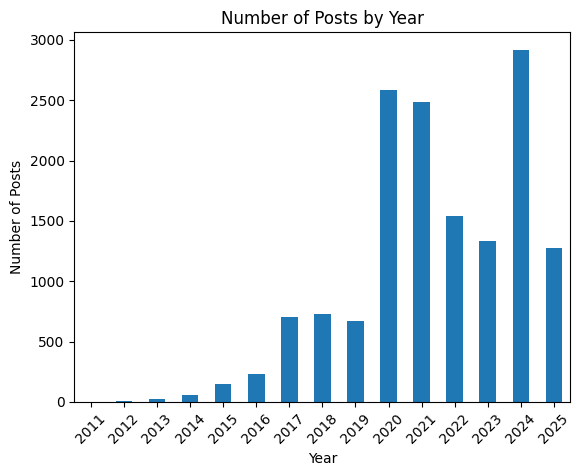

In [20]:

import matplotlib.pyplot as plt
yearly_dist = reddit.groupby('year').size().sort_index()
yearly_dist.plot(kind='bar')
plt.title('Number of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

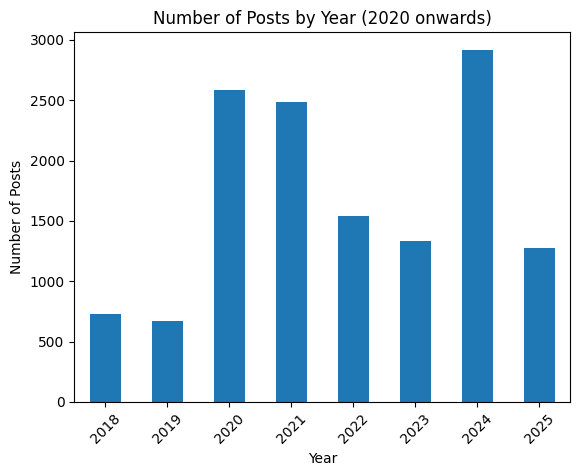

In [21]:
# Create a new dataframe with only 2018+ data
reddit = reddit[reddit['year'] >= 2018].copy()
# Now create the plot with cleaned data
yearly_dist = reddit.groupby('year').size().sort_index()
yearly_dist.plot(kind='bar')
plt.title('Number of Posts by Year (2020 onwards)')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

In [22]:
reddit.describe()

,Unnamed: 0.1,Unnamed: 0,score,upvote_ratio,created_utc,num_comments,year
count,13537.000000,13016.000000,13537.000000,13537.000000,13537,13537.000000,13537.000000
mean,13808.718401,13187.319069,1325.592746,0.836216,2022-04-30 02:34:40.165472256,286.605452,2021.884539
min,1.000000,1.000000,0.000000,0.100000,2018-01-02 00:00:00,1.000000,2018.000000
25%,6476.000000,6240.750000,14.000000,0.780000,2020-10-04 00:00:00,20.000000,2020.000000
50%,13006.000000,12464.500000,86.000000,0.880000,2022-02-28 00:00:00,63.000000,2022.000000
75%,21070.000000,20019.500000,697.000000,0.940000,2024-04-18 00:00:00,255.000000,2024.000000
max,29614.000000,28709.000000,228579.000000,1.000000,2025-04-07 00:00:00,98689.000000,2025.000000
std,8593.778319,8171.558829,5383.948561,0.140881,NaN,1318.248274,2.011906


In [23]:
# Merge df and reddit dataframes on Symbol and search_term columns
reddit_merge = pd.merge(df, reddit, 
                    left_on='Symbol',
                    right_on='search_term',
                    how='inner')
#  Drop unnecessary columns
reddit_merge = reddit_merge.drop(columns=['search_term','Unnamed: 0.1','Unnamed: 0_x','Unnamed: 0_y','permalink'])
# Drop rows where 'post' or 'comments' are NaN
reddit_merge = reddit_merge.dropna(subset = ['post','comments'])

In [24]:
reddit_merge['Security'].value_counts()

Security
ON Semiconductor           78
Gartner                    74
Advanced Micro Devices     73
Carnival                   72
Alphabet Inc. (Class A)    71
                           ..
GoDaddy                     3
News Corp (Class B)         2
Omnicom Group               2
News Corp (Class A)         2
Mohawk Industries           1
Name: count, Length: 138, dtype: int64

In [25]:
reddit_merge.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,post_id,title,...,created_utc,num_comments,author,url,is_self,flair,subreddit,category,comments,year
0,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,q2ayen,Dividends Plus Growth - Accenture (ACN),...,2021-10-06,10,mike_oc23,https://www.reddit.com/r/stocks/comments/q2aye...,True,NaN,stocks,stock_specific,"[""Ex-Acn here - all members of staff can also ...",2021
1,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,fikrze,Wall Street Week Ahead for the trading week be...,...,2020-03-14,184,bigbear0083,https://www.reddit.com/r/stocks/comments/fikrz...,True,News,stocks,stock_specific,"['Question from a newbie. From my knowledge, t...",2020
2,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,y4pqck,Which is the best SOFTWARE stock to buy now fo...,...,2022-10-15,217,giscafred,https://www.reddit.com/r/stocks/comments/y4pqc...,True,NaN,stocks,stock_specific,['Absolutely love ACN. Given the SaaS movement...,2022
3,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,ms4niw,The New Normal - 25% of the S&P 100 companies ...,...,2021-04-16,104,GMEgotmehere,https://www.reddit.com/r/stocks/comments/ms4ni...,True,NaN,stocks,stock_specific,['>and constantly regret not putting more cash...,2021
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,p6bsk7,"Here is a Market Recap for today Tuesday, Augu...",...,2021-08-17,53,psychotrader00,https://www.reddit.com/r/stocks/comments/p6bsk...,True,NaN,stocks,stock_specific,"['TLDR: RED', 'what day is Jpow schedule to sp...",2021


In [15]:
# Group by Symbol and get the top 60% of posts by num_comments for each Symbol
top_posts = (reddit_merge.groupby('Symbol')
             .apply(lambda x: x.nlargest(int(len(x) * 0.75), 'num_comments'))
             .reset_index(drop=True))

# Sort the final dataframe by Symbol and num_comments
top_posts = top_posts.sort_values(['Symbol', 'num_comments'], ascending=[True, False])

/var/folders/0w/q70p80s12nz5lpzr087614lw0000gn/T/ipykernel_57970/853144901.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(int(len(x) * 0.75), 'num_comments'))


### I am making sure I have pannel data where I have enough datapoints across different times

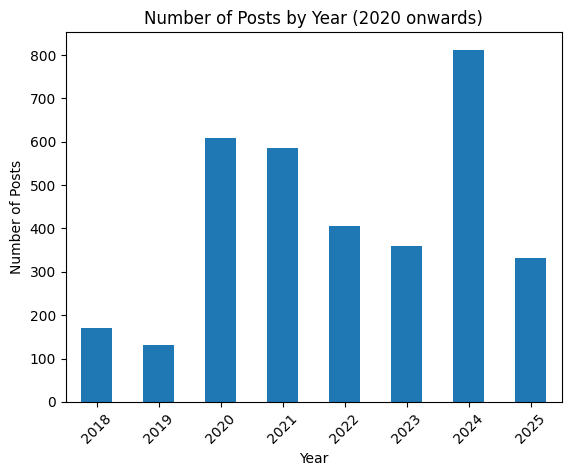

In [ ]:
# Now create the plot with cleaned data
yearly_dist = top_posts.groupby('year').size().sort_index()
yearly_dist.plot(kind='bar')
plt.title('Number of Posts by Year (2018 onwards)')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

### Based on these top posts I will create a Prompt that will analyze these Reddit data and give them a sentiment score based on their Title, Post text and comments section

### Prompt

In [26]:
top_posts['reddit_sentiment_prompt'] = (
    "**Role:** You are an expert financial analyst specializing in social media sentiment and alternative data.\n\n" +
    "**Objective:** The following data is for the stock ticker **" + top_posts['Symbol'] + "**. " +
    "Analyze the Reddit post and its associated comments to provide a structured summary of the discussion for a machine learning model.\n\n" +
    "**Input Data:**\n" +
    "**Ticker:** " + top_posts['Symbol'] + "\n" +
    "**Post Title:** " + top_posts['title'] + "\n" +
    "**Post Body:** " + top_posts['post'] + "\n" +
    "**Upvote Ratio:** " + top_posts['upvote_ratio'].astype(str) + "\n" +
    "**Number of Comments:** " + top_posts['num_comments'].astype(str) + "\n" +
    "**Comments:** " + top_posts['comments'] + "\n\n" +  
    "**Task:** Based on the input data, generate a single JSON object that structures the discussion's content and sentiment. " +
    "The analysis should clearly distinguish between the original post's claims and the community's response in the comments.\n\n" +
    "**JSON Output Schema:**\n" +
    "{\n" +
    "  \"post_summary\": {\n" +
    "    \"thesis\": \"Summarize the main point, argument, or question of the original post. What is the author claiming or asking?\",\n" +
    "    \"evidence_type\": \"Classify the type of evidence used in the post (e.g., 'Official Financials', 'Technical Analysis', 'Speculation', 'News Article', 'Personal Opinion').\"\n" +
    "  },\n" +
    "  \"comments_summary\": {\n" +
    "    \"main_theme\": \"Summarize the general sentiment and key themes of the comments. Are they in agreement or disagreement with the post?\",\n" +
    "    \"counter_arguments\": \"List the most significant counter-arguments or bearish points raised in the comments.\",\n" +
    "    \"corroborating_points\": \"List the most significant points from the comments that support or agree with the original post.\"\n" +
    "  },\n" +
    "  \"quantitative_analysis\": {\n" +
    "    \"sentiment_score\": \"[A float score from -1.0 (very bearish) to 1.0 (very bullish) for the entire discussion]\",\n" +
    "    \"sentiment_reasoning\": \"A brief explanation for the sentiment score, citing the balance between the post and the comments.\",\n" +
    "    \"conviction_level\": \"[Rate as 'Low', 'Medium', or 'High' based on the certainty and language used across the entire discussion.]\",\n" +
    "    \"predominant_emotion\": \"[e.g., 'Analytical', 'Fear', 'Greed', 'Uncertainty', 'Hope']\"\n" +
    "  },\n" +
    "  \"market_outlook\": \"[Classify the overall conclusive outlook for the ticker from this discussion as 'Bullish', 'Bearish', 'Neutral', or 'Contentious']\"\n" +
    "}\n\n" +
    "**Instructions:**\n" +
    "1. The analysis must focus only on the provided ticker: **" + top_posts['Symbol'] + "**.\n" +
    "2. Clearly separate the analysis of the Post Body from the Comments.\n" +
    "3. market_outlook should be 'Contentious' if there is strong disagreement between the post and comments or within the comments themselves.\n" +
    "4. Consider the upvote ratio (" + top_posts['upvote_ratio'].astype(str) + ") as an indicator of community agreement with the post.\n" +
    "5. Note that there are " + top_posts['num_comments'].astype(str) + " comments on this post.\n" +
    "6. Provide the final output in a single JSON block without any additional commentary."
)

In [27]:
import json
import time

def process_reddit_with_gemini(df, file_name, prompt_column='reddit_sentiment_prompt', max_retries=3):
    responses = []
    gemini_responses = []
    
    for index, row in df.iterrows():
        # Display progress with symbol and title (or just index if not available)
        display_text = f"{row['symbol']} - {row['title'][:50]}..." if 'symbol' in row and 'title' in row else f"Row {index}"
        print(f"Processing {index + 1}/{len(df)}: {display_text}")
        
        retry_count = 0
        success = False
        
        while retry_count < max_retries and not success:
            try:
                prompt = row[prompt_column]
                
                response = model.generate_content(prompt)
                response_text = response.text
                
                responses.append(response_text)
                gemini_responses.append(response_text)
                success = True
                time.sleep(0.01)
                
            except Exception as e:
                retry_count += 1
                print(f"Error on attempt {retry_count}: {str(e)}")
                
                if retry_count < max_retries:
                    wait_time = 65 if "rate limit" in str(e).lower() else 5
                    print(f"Waiting {wait_time} seconds before retry...")
                    time.sleep(wait_time)
                else:
                    error_text = f"Error after {retry_count} attempts: {str(e)}"
                    responses.append(error_text)
                    gemini_responses.append(error_text)
    
    df['gemini_response'] = responses
    
    with open(file_name, 'w', encoding='utf-8') as f:
        json.dump(gemini_responses, f, ensure_ascii=False, indent=2)
    
    return df


In [28]:
import json

# Method 1: Display full text of a specific cell without truncation
#pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', None)



# Reset display options if needed
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')

In [29]:
top_posts.describe()

,CIK,score,upvote_ratio,created_utc,num_comments,year
count,3.404000e+03,3404.000000,3404.000000,3404,3404.000000,3404.000000
mean,9.511803e+05,1616.138954,0.851998,2022-06-22 21:37:51.680376064,324.217098,2022.028790
min,2.488000e+03,0.000000,0.100000,2018-01-06 00:00:00,1.000000,2018.000000
25%,7.492510e+05,27.750000,0.800000,2020-11-26 18:00:00,36.000000,2020.000000
50%,1.018724e+06,151.000000,0.890000,2022-05-27 00:00:00,110.500000,2022.000000
75%,1.341439e+06,957.750000,0.940000,2024-05-16 18:00:00,361.250000,2024.000000
max,1.754301e+06,228579.000000,1.000000,2025-04-07 00:00:00,17796.000000,2025.000000
std,5.028570e+05,7229.809599,0.122307,NaN,729.695193,1.993022


In [30]:
# Filter top_posts to keep only data from years 2018 and 2019
top_posts_1819 = top_posts[top_posts['year'].isin([2018, 2019])].copy()

# Display the count to verify
print(f"Number of posts from 2018-2019: {len(top_posts_1819)}")
print(top_posts_1819['year'].value_counts())

Number of posts from 2018-2019: 302
year
2018    171
2019    131
Name: count, dtype: int64


In [33]:
# For Reddit analysis
file_name_reddit = 'gemini_reddit_analysis_1819.json'
df_reddit_processed = process_reddit_with_gemini(top_posts_1819, file_name_reddit, 'reddit_sentiment_prompt')
df_reddit_processed.to_csv('./data/reddit_analysis_results_1819.csv', index=False)

Processing 26/302: Row 25
Processing 81/302: Row 80
Processing 84/302: Row 83
Processing 93/302: Row 92
Processing 136/302: Row 135
Processing 138/302: Row 137
Processing 145/302: Row 144
Processing 147/302: Row 146
Processing 170/302: Row 169
Processing 172/302: Row 171
Processing 175/302: Row 174
Processing 176/302: Row 175
Processing 177/302: Row 176
Processing 178/302: Row 177
Processing 179/302: Row 178
Processing 184/302: Row 183
Processing 185/302: Row 184
Processing 187/302: Row 186
Processing 188/302: Row 187
Processing 191/302: Row 190
Processing 195/302: Row 194
Processing 198/302: Row 197
Processing 208/302: Row 207
Processing 256/302: Row 255
Processing 280/302: Row 279
Processing 283/302: Row 282
Processing 285/302: Row 284
Processing 289/302: Row 288
Processing 292/302: Row 291
Processing 304/302: Row 303
Processing 306/302: Row 305
Processing 313/302: Row 312
Processing 314/302: Row 313
Processing 315/302: Row 314
Processing 328/302: Row 327
Processing 365/302: Row 364


In [56]:
# For Reddit analysis
df_test = top_posts.head(3)
file_name_reddit = 'gemini_reddit_analysis.json'
df_reddit_processed = process_reddit_with_gemini(top_posts, file_name_reddit, 'reddit_sentiment_prompt')
df_reddit_processed.to_csv('./data/reddit_analysis_results.csv', index=False)

Processing 1/3025: Row 0
Processing 2/3025: Row 1
Processing 3/3025: Row 2
Processing 4/3025: Row 3
Processing 5/3025: Row 4
Processing 6/3025: Row 5
Processing 7/3025: Row 6
Processing 8/3025: Row 7
Processing 9/3025: Row 8
Processing 10/3025: Row 9
Processing 11/3025: Row 10
Processing 12/3025: Row 11
Processing 13/3025: Row 12
Processing 14/3025: Row 13
Processing 15/3025: Row 14
Processing 16/3025: Row 15
Processing 17/3025: Row 16
Processing 18/3025: Row 17
Processing 19/3025: Row 18
Processing 20/3025: Row 19
Processing 21/3025: Row 20
Processing 22/3025: Row 21
Processing 23/3025: Row 22
Processing 24/3025: Row 23
Processing 25/3025: Row 24
Processing 26/3025: Row 25
Processing 27/3025: Row 26
Processing 28/3025: Row 27
Processing 29/3025: Row 28
Processing 30/3025: Row 29
Processing 31/3025: Row 30
Processing 32/3025: Row 31
Processing 33/3025: Row 32
Processing 34/3025: Row 33
Processing 35/3025: Row 34
Processing 36/3025: Row 35
Processing 37/3025: Row 36
Processing 38/3025: 

### General posts

In [ ]:
# Filter for general category and sort by num_comments
general_posts = reddit[reddit['category'] == 'general'].sort_values('num_comments', ascending=False).head(80)

# Reset index for clean output
general_posts = general_posts.reset_index(drop=True)
general_posts.tail()

# Text analysis:

This section's main goal is to make the text data analysable by a machine learning algorithm

# For Local Gemma3 Models (NO APIs) -- I am using the GEMINI Model so this is just for it to stay here

In [ ]:
import json
import os
import time
import pandas as pd
import google.generativeai as genai
from datetime import datetime
from pathlib import Path

def load_mappings(mapping_file_path):
    """Load the industry mappings from JSON file"""
    try:
        with open(mapping_file_path, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"Mapping file not found: {mapping_file_path}")
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid JSON in mapping file: {e}")

def construct_prompt(industry_mapping, extracted_answer, supporting_quote=""):
    """Construct the categorization prompt for a specific industry and answer"""
    
    industry_mapping_json = json.dumps(industry_mapping, indent=2)
    
    prompt = f"""You are a financial analyst engine. Your task is to categorize a piece of text extracted from a company's 10-K filing by mapping it to a specific strategic category from the provided JSON framework.

**Your Goal:**
Based on the "Extracted Answer," find the single best-fit category from the `INDUSTRY_FRAMEWORK_JSON` provided below, and determine the specific SWOT classification and Porter's Five Forces that apply.

**IMPORTANT: Your response MUST be ONLY a valid JSON object in this exact format:**
{{
  "best_fit_category": "[The 'label' of the best-fit category from the framework]",
  "category_type": "[The type of category: 'moat', 'risk', or 'kpi']",
  "confidence_of_fit": "[A score from 0.0 to 1.0 on how well the text fits this category]",
  "swot_classification": "[Based on the answer content, which SWOT category applies: 'Strength', 'Weakness', 'Opportunity', or 'Threat']",
  "porters_forces": ["[List of Porter's Five Forces that apply from the mapping]"],
  "justification": "[A brief explanation of why the text fits this category and why you chose the specific SWOT classification]"
}}

**Instructions:**
1. Analyze the `Extracted Answer` and its `Supporting Quote`.
2. Review the `INDUSTRY_FRAMEWORK_JSON` to understand the available categories and their definitions.
3. Select the `label` of the single category that best matches the text.
4. Determine the `category_type` by looking at whether the chosen label is under the `moats`, `risks`, or `kpis` key in the framework.
5. Based on the content of the answer, determine which SWOT classification applies:
   - Choose "Strength" if the answer shows a positive internal capability or advantage
   - Choose "Weakness" if the answer shows a negative internal limitation or disadvantage
   - Choose "Opportunity" if the answer shows a positive external trend or possibility
   - Choose "Threat" if the answer shows a negative external risk or challenge

   - Note: The chosen SWOT classification should be one of the options listed in the category's mapping.swot array

6. Based on the answer, determine the single most relevant Porter's Five Forces classification from the category's `mapping.porters` array. Evaluate the force's impact on the company:
   - Choose a "High" variant (e.g., `High Intensity of Rivalry`, `High Bargaining Power of Buyers`) if the force exerts strong competitive pressure or presents a significant challenge.
   - Choose a "Low" variant (e.g., `Low Intensity of Rivalry`, `Low Bargaining Power of Buyers`) if the force exerts weak pressure or represents a structural advantage for the company.
   - For example, if the text describes significant barriers that make it difficult for new competitors to enter the market, you would select `Low Threat of New Entrants`.

7. If the text does not clearly fit any of the provided categories, you MUST respond with:
   {{
     "best_fit_category": "No Clear Fit",
     "category_type": "none",
     "confidence_of_fit": 0.0,
     "swot_classification": "none",
     "porters_forces": [],
     "justification": "The text does not contain specific information that aligns with any of the defined moats, risks, or KPIs."
   }}

---
**INDUSTRY_FRAMEWORK_JSON:**
{industry_mapping_json}
---
**Extracted Answer:**
{extracted_answer}

**Supporting Quote:**
{supporting_quote}
---"""
    
    return prompt

def categorize_with_gemini(industry_mapping, extracted_answer, supporting_quote="", model=None, max_retries=3):
    """
    Categorize using Google's Gemini model with retry logic
    
    Args:
        industry_mapping: The industry mapping dict from JSON
        extracted_answer: The main answer text to categorize
        supporting_quote: Optional supporting quote from the 10-K
        model: Gemini model instance (optional, will create if not provided)
        max_retries: Maximum number of retry attempts
    
    Returns:
        Dict with categorization results
    """
    # Initialize Gemini if not provided
    if model is None:
        api_key = os.getenv('GEMINI_API_KEY')
        if not api_key:
            raise ValueError("GEMINI_API_KEY environment variable not set")
        genai.configure(api_key=api_key)
        model = genai.GenerativeModel('gemini-2.5-flash-preview-05-20')
    
    # Validate inputs
    if not extracted_answer or pd.isna(extracted_answer):
        return {
            "best_fit_category": "Empty Answer",
            "category_type": "error",
            "confidence_of_fit": 0.0,
            "swot_classification": "none",
            "porters_forces": [],
            "justification": "No answer text provided"
        }
    
    # Construct the prompt
    prompt = construct_prompt(industry_mapping, extracted_answer, supporting_quote)
    
    # Retry logic
    retry_count = 0
    base_wait_time = 60
    
    while retry_count < max_retries:
        try:
            # Call Gemini
            response = model.generate_content(prompt)
            
            # Extract JSON from response
            response_text = response.text.strip()
            
            # Clean up the response if needed (remove markdown code blocks)
            if response_text.startswith('```json'):
                response_text = response_text[7:]
            if response_text.endswith('```'):
                response_text = response_text[:-3]
            
            # Parse the JSON response
            result = json.loads(response_text.strip())
            
            # Validate the response structure
            required_keys = ['best_fit_category', 'category_type', 'confidence_of_fit', 
                            'swot_classification', 'porters_forces', 'justification']
            if all(key in result for key in required_keys):
                return result
            else:
                raise ValueError(f"Missing required keys in response: {result}")
                
        except genai.types.generation_types.BlockedPromptException as e:
            # Don't retry blocked prompts
            return {
                "best_fit_category": "Blocked Prompt",
                "category_type": "error",
                "confidence_of_fit": 0.0,
                "swot_classification": "none",
                "porters_forces": [],
                "justification": f"Prompt blocked by safety filters: {str(e)}"
            }
            
        except json.JSONDecodeError as e:
            retry_count += 1
            if retry_count < max_retries:
                wait_time = base_wait_time * (2 ** (retry_count - 1))
                print(f"JSON decode error, retrying in {wait_time}s: {str(e)}")
                time.sleep(wait_time)
            else:
                return {
                    "best_fit_category": "JSON Parse Error",
                    "category_type": "error",
                    "confidence_of_fit": 0.0,
                    "swot_classification": "none",
                    "porters_forces": [],
                    "justification": f"Could not parse JSON response after {max_retries} attempts"
                }
                
        except Exception as e:
            retry_count += 1
            if retry_count < max_retries:
                wait_time = base_wait_time * (2 ** (retry_count - 1))
                print(f"Error on attempt {retry_count}, retrying in {wait_time}s: {str(e)}")
                time.sleep(wait_time)
            else:
                return {
                    "best_fit_category": "Error",
                    "category_type": "error",
                    "confidence_of_fit": 0.0,
                    "swot_classification": "none",
                    "porters_forces": [],
                    "justification": f"Error after {max_retries} attempts: {str(e)}"
                }

def process_dataframe(df, mapping_file_path, output_folder='categorization_results', 
                     gics_to_mapping_dict=None, delay_seconds=1.0):
    """
    Process a dataframe with columns: answer, supporting_quote, GICS Sub-Industry, Symbol
    
    Args:
        df: DataFrame with required columns
        mapping_file_path: Path to the mapping.json file
        output_folder: Folder to save per-ticker results
        gics_to_mapping_dict: Dict mapping GICS Sub-Industry to mapping.json keys
        delay_seconds: Delay between API calls
    
    Returns:
        DataFrame with original columns plus categorization results
    """
    # Create output folder
    output_path = Path(output_folder)
    output_path.mkdir(exist_ok=True)
    
    
    # Load mappings
    mappings = load_mappings(mapping_file_path)
    
    # Initialize Gemini model
    api_key = os.getenv('GEMINI_API_KEY')
    if not api_key:
        raise ValueError("GEMINI_API_KEY environment variable not set")
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel('gemini-2.5-flash-preview-05-20')
    
    # Group by ticker if Symbol column exists
    if 'Symbol' in df.columns:
        grouped = df.groupby('Symbol')
    else:
        # Process as single group if no Symbol column
        grouped = [('all_data', df)]
    
    all_results = []
    
    # Process each ticker group
    for ticker, ticker_df in grouped:
        print(f"\n{'='*50}")
        print(f"Processing ticker: {ticker}")
        print(f"Rows to process: {len(ticker_df)}")
        
        # Create ticker-specific folder
        ticker_folder = output_path / f"{ticker}"
        ticker_folder.mkdir(exist_ok=True)
        
        # Store results for this ticker
        ticker_results = []
        
        for idx, (_, row) in enumerate(ticker_df.iterrows()):
            # Get the industry mapping
            gics_industry = row['GICS Sub-Industry']
            
            # Map GICS to your mapping.json key (if mapping provided)
            if gics_to_mapping_dict:
                industry_key = gics_to_mapping_dict.get(gics_industry, gics_industry)
            else:
                industry_key = gics_industry
            
            print(f"\nProcessing row {idx+1}/{len(ticker_df)} - Industry: {gics_industry}")
            
            # Skip if industry not in mappings
            if industry_key not in mappings:
                result = {
                    "best_fit_category": "Industry Not Found",
                    "category_type": "error",
                    "confidence_of_fit": 0.0,
                    "swot_classification": "none",
                    "porters_forces": [],
                    "justification": f"Industry '{industry_key}' not found in mapping file"
                }
            else:
                # Categorize the answer with retry logic
                result = categorize_with_gemini(
                    industry_mapping=mappings[industry_key],
                    extracted_answer=row['answer'],
                    supporting_quote=row.get('supporting_quote', ''),
                    model=model,
                    max_retries=3
                )
            
            # Add metadata
            result['ticker'] = ticker
            result['row_index'] = idx
            
            ticker_results.append(result)
            
            # Save intermediate results for this ticker
            if (idx + 1) % 10 == 0 or idx == len(ticker_df) - 1:
                intermediate_df = pd.DataFrame(ticker_results)
                intermediate_file = ticker_folder / f"{ticker}_intermediate_{idx+1}.json"
                intermediate_df.to_json(intermediate_file, orient='records', indent=2)
                print(f"Saved intermediate results to {intermediate_file}")
            
            # Rate limiting
            if idx < len(ticker_df) - 1:
                time.sleep(delay_seconds)
        
        # Create results dataframe for this ticker
        results_df = pd.DataFrame(ticker_results)
        
        # Combine with original ticker dataframe
        ticker_df_reset = ticker_df.reset_index(drop=True)
        ticker_final = pd.concat([ticker_df_reset, results_df], axis=1)
        
        # Save ticker results
        ticker_csv = ticker_folder / f"{ticker}_categorized.csv"
        ticker_json = ticker_folder / f"{ticker}_categorized.json"
        
        ticker_final.to_csv(ticker_csv, index=False)
        ticker_final.to_json(ticker_json, orient='records', indent=2)
        
        print(f"\nSaved {ticker} results:")
        print(f"  CSV: {ticker_csv}")
        print(f"  JSON: {ticker_json}")
        
        all_results.append(ticker_final)
    
    # Combine all results
    if all_results:
        df_final = pd.concat(all_results, ignore_index=True)
        
        # Save combined results
        combined_csv = output_path / f"all_categorized_.csv"
        combined_json = output_path / f"all_categorized.json"
        
        df_final.to_csv(combined_csv, index=False)
        df_final.to_json(combined_json, orient='records', indent=2)
        
        print(f"\n{'='*50}")
        print(f"Processing complete!")
        print(f"Combined results saved to:")
        print(f"  CSV: {combined_csv}")
        print(f"  JSON: {combined_json}")
        print(f"Individual ticker results in: {output_path}")
        
        return df_final
    else:
        print("No results to save")
        return pd.DataFrame()

# Usage example:
try:
    df_results = process_dataframe(
        df=df_cleaned,
        mapping_file_path='mapping.json',
        output_folder='categorization_results',
        # gics_to_mapping_dict=gics_mapping,  # Optional if names match exactly
        delay_seconds=0.01
    )
    print("\nCategorization completed successfully!")
except Exception as e:
    print(f"\nFatal error: {str(e)}")
    print("Check partial results in the output folder")

In [ ]:
import pandas as pd
import requests
from tqdm.notebook import tqdm

# Define questions for each section
Business = """
1.  What is the company's primary business and what main products or services does it offer?
2.  What is the company's general business model or how does it primarily generate revenue as described?
3.  What are the main operating segments of the company, if discussed?
4.  What primary markets (e.g., geographic, customer types, industries) does the company serve?
5.  Who are the main competitors mentioned in this section?
6.  How does the company generally manage its operations, such as manufacturing, sourcing, or distribution?
7.  What is the general approach to sales and marketing described?
8.  Is intellectual property mentioned as important to the business, and if so, how?
9.  What is the approximate number of employees mentioned?
10. What significant government regulations are described as applicable to the company's business?
"""

RiskFactors = """
1.  What are the main categories or types of risks disclosed in this section?
2.  What are identified as the most significant overall risks to the company's business or financial condition?
3.  What key risks are mentioned related to the company's industry, markets, economic conditions, or competition?
4.  What key risks are mentioned related to the company's products, services, technology, cybersecurity, or intellectual property?
5.  What key risks are mentioned related to the company's operations, supply chain, manufacturing, or infrastructure?
6.  What key risks are mentioned related to legal, regulatory, compliance matters, or potential litigation?
7.  What key risks are mentioned related to the company's financial condition, liquidity, or access to capital?
8.  Are there any significant risks mentioned related to personnel, management, or key employees?
9.  Are there any risks mentioned related to external events such as natural disasters, pandemics, or geopolitical issues?
10. Are there any risks mentioned related to the company's inability to successfully implement its strategies (e.g., M&A integration risks, new market entry risks)?
"""

Unresolved = """
1.  Are there any unresolved SEC staff comments disclosed?
2.  What is the nature of these unresolved comments?
3.  How long have these comments been outstanding?
4.  What is the potential impact or required action if these comments are resolved unfavorably for the company?
5.  Do the comments suggest potential issues with the company's accounting practices or transparency?
"""

Cybersecurity = """
1. What is the company's general approach to cybersecurity risk management?
2. Is there a specific team or individuals responsible for cybersecurity?
3. What specific cybersecurity risks does the company identify?
4. Has the company experienced any material cybersecurity incidents?
5. What measures or controls does the company have in place to address cybersecurity risks?
6. Does the company mention any third-party assessments or standards they follow?
7. Is there board oversight of cybersecurity risks, and if so, how is it described?
8. Does the company have specific cybersecurity training programs mentioned?
9. Are there any industry-specific cybersecurity regulations mentioned?
10. How does the company approach data protection and privacy?
"""

Properties = """
1.  What are the company's most significant physical properties?
2.  Where are these principal properties located geographically?
3.  Are the key properties owned or leased, and what are the terms of any significant leases?
4.  Is the described capacity and condition of the properties sufficient for current and planned operations?
5.  Are there any material encumbrances or environmental issues noted regarding the properties?
6.  How do the properties described align with and support the company's overall business strategy and segment operations?
"""

LegalProceedings = """
1.  Are there any material legal proceedings disclosed?
2.  What is the nature of the material proceedings?
3.  Who are the key parties involved in the litigation?
4.  What stage are the material proceedings currently in?
5.  Has the company estimated the potential range of loss or impact?
6.  What is the potential impact of an unfavorable outcome on the company?
7.  Are any of the proceedings brought by or against governmental authorities?
"""

ManagementDiscussion = """
1.  What are the key factors management highlights as driving the changes in revenue, costs, and profitability for the reported periods?
2.  How does management explain the performance and key trends within the company's different operating segments?
3.  What significant non-recurring items, unusual events, or accounting changes does management discuss as impacting the results?
4.  What known trends, events, or uncertainties does management identify as reasonably likely to have a material effect on future financial condition or results of operations?
5.  What is management's discussion of the company's liquidity and capital resources?
6.  What are identified as the primary sources and uses of cash during the periods presented?
7.  What are the company's material cash requirements from known contractual obligations, commitments, or debt maturities?
8.  How has the company's capital structure (e.g., debt-to-equity ratio) changed, and what is management's commentary on it?
9.  What are the critical accounting estimates identified by management?
10. Why are these estimates considered critical, and what are the key assumptions or uncertainties underlying them?
11. How does management explain the sensitivity of the financial statements to changes in these critical accounting estimates?
"""

QuantitativeDisclosures = """
1.  What are the primary market risks the company is disclosed as being exposed to?
2.  How does management describe the nature of these market risk exposures?
3.  What are the company's stated objectives and general strategies for managing these market risks?
4.  Does the company disclose the use of derivative financial instruments for hedging market risks? If so, how are they generally used?
5.  Does the company mention holding derivative instruments for trading or speculative purposes?
6.  What quantitative information is provided about the potential impact of changes in interest rates?
7.  What quantitative information is provided about the potential impact of changes in foreign currency exchange rates?
8.  What quantitative information is provided about the potential impact of changes in commodity prices?
9.  What quantitative information is provided about the potential impact of changes in equity prices, if any?
10. What methods (e.g., sensitivity analysis, Value at Risk - VAR) are mentioned as being used for the quantitative market risk analysis? What are the key assumptions of the method used?
""" 

# Map section names to their question lists
section_question_map = {
    "Item 1. Business": Business,
    "Item 1A. Risk Factors": RiskFactors,
    "Item 1B. Unresolved Staff Comments" : Unresolved,
    "Item 1C. Cybersecurity": Cybersecurity,
    "Item 2. Properties": Properties,
    "Item 3. Legal Proceedings": LegalProceedings,
    "Item 7. Management Discussion and Analysis": ManagementDiscussion,
    "Item 7A. Quantitative and Qualitative Disclosures about Market Risk": QuantitativeDisclosures
}

def call_local_gemma(prompt, temperature=0.1):
    """
    Call the local Ollama Gemma model and return raw output
    """
    # Set up Ollama API request
    api_url = "http://localhost:11434/api/generate"
    payload = {
        "model": "gemma3:4b-it-qat",  # Using Gemma 3 model
        "prompt": prompt,
        "temperature": temperature,
        "stream": False
    }
    
    # Make API call
    try:
        print("Sending prompt to local Gemma model...")
        response = requests.post(api_url, json=payload)
        if response.status_code == 200:
            result = response.json()
            return result.get("response", "No response")
        else:
            print(f"Error: {response.status_code}")
            return f"Error: {response.status_code}"
    except Exception as e:
        print(f"Connection error: {str(e)}")
        return f"Connection error: {str(e)}"

def process_10k_sections(df):
    """
    Process each section and display raw outputs without parsing
    """
    # Identify the section columns
    section_columns = [col for col in df.columns if col in section_question_map]
    
    if not section_columns:
        # Try with partial matching if exact matches aren't found
        section_columns = []
        for col in df.columns:
            for section_name in section_question_map.keys():
                if section_name.lower() in col.lower():
                    section_columns.append(col)
                    break
    
    print(f"Found {len(section_columns)} section columns: {section_columns}")
    
    # Process each row in the dataframe
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing companies"):
        ticker = row.get('ticker', f"Company_{idx}")
        filing_date = row.get('filing_date', 'Unknown')
        
        print(f"\n\n{'='*80}")
        print(f"PROCESSING: {ticker} - Filing Date: {filing_date}")
        print(f"{'='*80}")
        
        # Process each section
        for section_col in section_columns:
            content = row.get(section_col)
            
            # Skip if no content
            if pd.isna(content) or str(content).strip() == "" or str(content).lower() == "nan":
                print(f"Skipping {ticker} {section_col} - no content")
                continue
            
            # Find the matching question set
            section_name = None
            question_list = None
            
            # Try exact match first
            if section_col in section_question_map:
                section_name = section_col
                question_list = section_question_map[section_col]
            else:
                # Try partial matching
                for key in section_question_map.keys():
                    if key.lower() in section_col.lower():
                        section_name = key
                        question_list = section_question_map[key]
                        break
            
            if not section_name or not question_list:
                continue
                
            # Create the prompt
            # Create the prompt
            
            
            # Call the Gemma model and display raw output
            try:
                print(f"\n\n{'-'*80}")
                print(f"SECTION: {section_name}")
                print(f"{'-'*80}")
                
                raw_response = call_local_gemma(prompt)
                
                print("\nRAW MODEL OUTPUT:")
                print(f"{'-'*40}")
                print(raw_response)
                print(f"{'-'*40}")
                
            except Exception as e:
                print(f"Error processing {ticker} {section_name}: {str(e)}")

# Function to test the Gemma model with a sample prompt
def test_gemma_with_sample():
    sample_prompt = """
    You are an information extraction bot.
    Based strictly and only on the text provided, answer the following questions.
    Your output must be **ONLY** the numbered answers, formatted as a numbered list (e.g., '1. [Answer]').
    
    **Text:**
    This is a sample company description. The company produces software for healthcare providers.
    They have approximately 5,000 employees and operate mainly in North America and Europe.
    Their main competitors are XYZ Corp and ABC Inc.
    
    ---
    **Questions:**
    1. What is the company's primary business?
    2. How many employees does the company have?
    3. Where does the company operate?
    4. Who are the main competitors?
    """
    
    print("\nTesting Gemma with sample prompt...")
    raw_response = call_local_gemma(sample_prompt)
    print("\nSAMPLE RAW OUTPUT:")
    print(f"{'-'*40}")
    print(raw_response)
    print(f"{'-'*40}")

# Example usage:
# First test with a sample prompt
#test_gemma_with_sample()

# Then process the actual data
#df = pd.read_csv('your_10k_data.csv')  # Replace with your actual data loading
process_10k_sections(df)

ModuleNotFoundError: No module named 'pandasbuy'